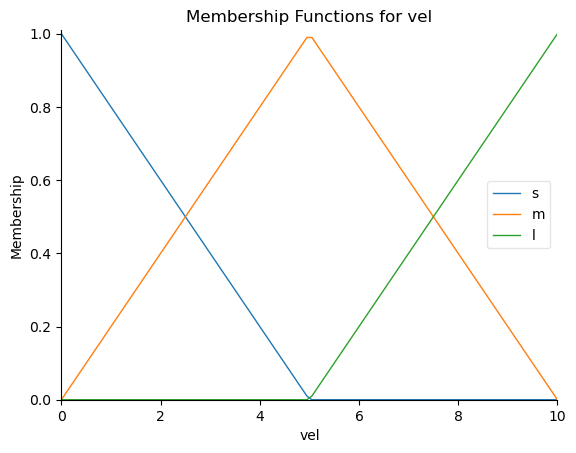

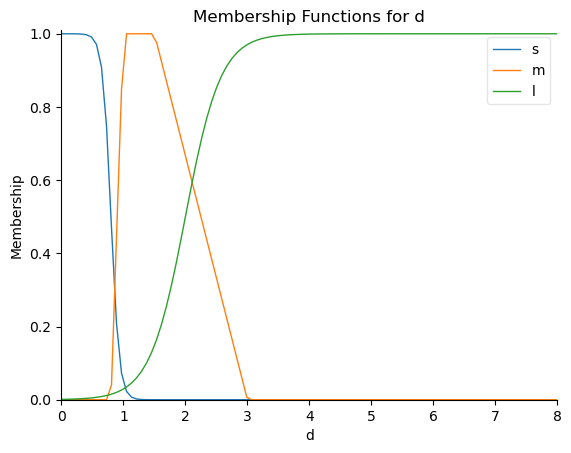

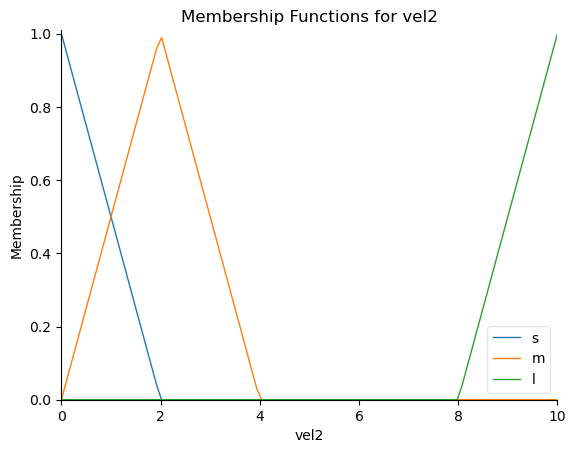

In [25]:
import vrep 
import sys
import time 
import numpy as np
from tank import *

import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

vel = ctrl.Antecedent(np.linspace(0, 10, 100), 'vel')
d = ctrl.Antecedent(np.linspace(0, 8, 100), 'd')
vel2 = ctrl.Consequent(np.linspace(0, 10, 100), 'vel2')

vel['s'] = fuzz.trimf(vel.universe, [0, 0, 5])
vel['m'] = fuzz.trimf(vel.universe, [0, 5, 10])
vel['l'] = fuzz.trimf(vel.universe, [5, 10, 10])

d['s'] = fuzz.sigmf(d.universe, 0.8, -15)
d['m'] = fuzz.trapmf(d.universe, [0.8, 1, 1.5, 3])
d['l'] = fuzz.sigmf(d.universe, 2, 3.5)

vel2['s'] = fuzz.trimf(vel2.universe, [-2, 0, 2])
vel2['m'] = fuzz.trimf(vel2.universe, [0, 2, 4])
vel2['l'] = fuzz.trimf(vel2.universe, [8, 10, 10])

rules = [
    ctrl.Rule(d['l'] & vel['s'], vel2['m']),
    ctrl.Rule(d['l'] & (vel['m'] | vel['l']), vel2['l']),

    ctrl.Rule(d['s'], vel2['s']),
    ctrl.Rule(vel['l'], vel2['l']),
]

model = ctrl.ControlSystem(rules)
vest = ctrl.ControlSystemSimulation(model)

vel.view()
plt.title('Membership Functions for vel')
plt.show()
d.view()
plt.title('Membership Functions for d')
plt.show()
vel2.view()
plt.title('Membership Functions for vel2')
plt.show()

def get_sharp_vel(V, dist):
    vest.input['vel'] = V
    vest.input['d'] = dist
    vest.compute()
    new_velocity = vest.output['vel2']
    if new_velocity < 2:
        return 0
    return new_velocity

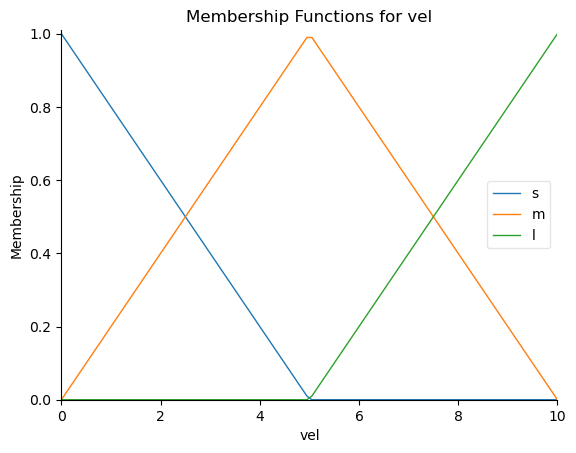

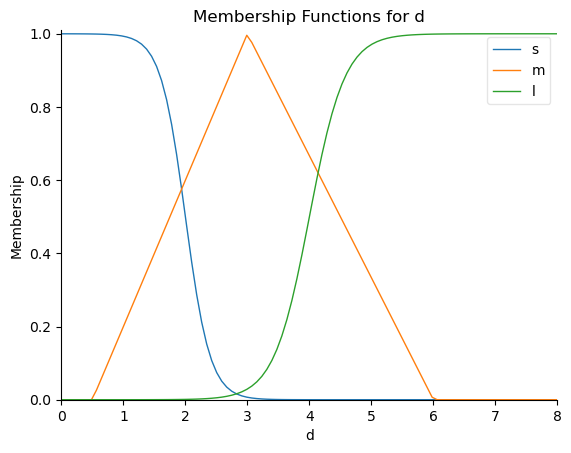

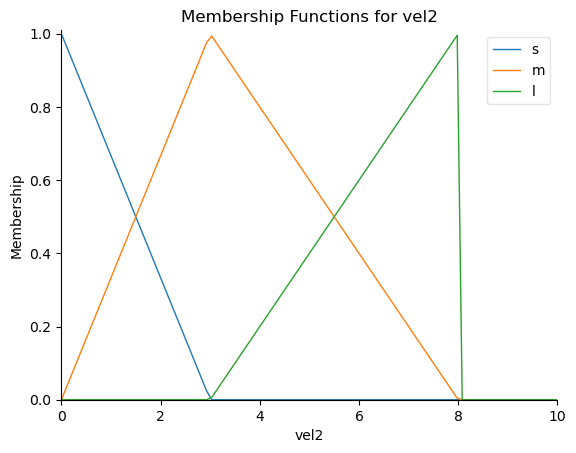

In [29]:
vel = ctrl.Antecedent(np.linspace(0, 10, 100), 'vel')
d = ctrl.Antecedent(np.linspace(0, 8, 100), 'd')
vel2 = ctrl.Consequent(np.linspace(0, 10, 100), 'vel2')

vel['s'] = fuzz.trimf(vel.universe, [0, 0, 5])
vel['m'] = fuzz.trimf(vel.universe, [0, 5, 10])
vel['l'] = fuzz.trimf(vel.universe, [5, 10, 10])

d['s'] = fuzz.sigmf(d.universe, 2, -5)
d['m'] = fuzz.trimf(d.universe, [0.5, 3, 6])
d['l'] = fuzz.sigmf(d.universe, 4, 3.5)

vel2['s'] = fuzz.trimf(vel2.universe, [0, 0, 3])
vel2['m'] = fuzz.trimf(vel2.universe, [0, 3, 8])
vel2['l'] = fuzz.trimf(vel2.universe, [3, 8, 8])

rules2 = [
    ctrl.Rule(d['l'] & (vel['s']), vel2['l']),
    ctrl.Rule(d['m'] & vel['l'], vel2['s']),

    ctrl.Rule(d['m'] & (vel['s'] | vel['m']), vel2['m']),
    ctrl.Rule(d['l'] & (vel['m'] | vel['l']), vel2['l']),

    ctrl.Rule(d['s'], vel2['s']),
    ctrl.Rule(d['l'], vel2['l']),
]

model2 = ctrl.ControlSystem(rules2)
vest2 = ctrl.ControlSystemSimulation(model2)

vel.view()
plt.title('Membership Functions for vel')
plt.show()
d.view()
plt.title('Membership Functions for d')
plt.show()
vel2.view()
plt.title('Membership Functions for vel2')
plt.show()

def get_soft_vel(V, dist):
    vest2.input['vel'] = V
    vest2.input['d'] = dist
    vest2.compute()
    new_velocity = vest2.output['vel2']
    if new_velocity < 1:
        return 0
    return new_velocity


Connected to remote API server


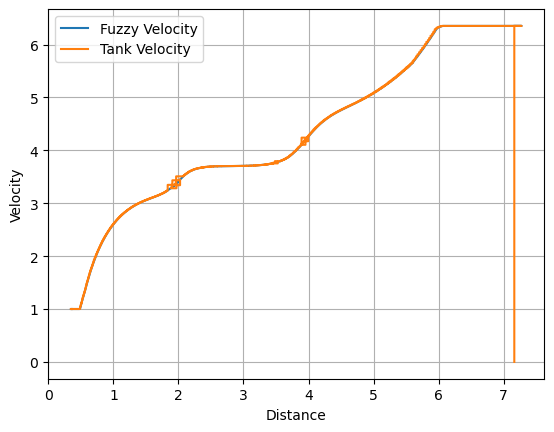

In [30]:
def get_velocity(velocity, distance, method):
    if method == 'soft':
        return get_soft_vel(velocity, distance)
    elif method == 'sharp':
        return get_sharp_vel(velocity, distance)
    else:
        raise ValueError('Method not supported')

vrep.simxFinish(-1)
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) 

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

tank=Tank(clientID)

err_code,ps_handle = vrep.simxGetObjectHandle(clientID,"Proximity_sensor", vrep.simx_opmode_blocking)

method = 'soft'

dist = []
fuzzy_vel = []
tank_vel = []
t = time.time()
while (time.time()-t)<15: 
    err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,ps_handle,vrep.simx_opmode_streaming)
    distance = np.linalg.norm(detectedPoint)
    if distance == 0:
        continue
    
    velocity = tank.readVelocity()
    fuzzy_velocity = get_velocity(velocity, distance, method)
    tank.forward(fuzzy_velocity)
    tank_vel.append(velocity)
    dist.append(distance)
    fuzzy_vel.append(fuzzy_velocity)


vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot)
plt.plot(dist, fuzzy_vel, label='Fuzzy Velocity')
plt.plot(dist, tank_vel, label='Tank Velocity')
plt.xlabel('Distance')
plt.ylabel('Velocity')
plt.grid()
plt.legend()
plt.show()